In [ ]:
  У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы
хотим развивать, наполняя новыми пользователями и поддерживая их активность.
  Команда ML сделала два алгоритма рекомендаций которые улучшают ленту:
1) Показываем пользователю посты, наиболее похожие на те, которые он лайкал. (группа 2)
2) Показываем пользователю посты, которые лайкали похожие на него пользователи.  (группа 3)
  Ожидается, что новые алгоритмы сделают пользователей счастливее (то есть удлинится LTV, повысятся денежные
конверсии и т.д.) а продукт удобнее/приятнее в использовании.
Мы тестируем метрику CTR, поскольку она учитывает "базовую" активность (просмотры). Это делает её более надёжной
для оценки изменений в заинтересованности, чем абсолютные значения лайков.

In [ ]:
Здание: провести AB тесты по принципам линеаризации "метрики отношения" (придумали Яндеском) для
групп 0 -3 и 1 - 2, сравнить результаты обычных тестов и ленеаризованных.
Эксперимент с 2025-01-03 по 2025-01-09 включительно. Для эксперимента были задействованы 2 и 1 группы.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandahouse as ph
import pandas as pd

In [ ]:
# Подключение к ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос данных для групп 0 и 3
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-09')
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""
# Запрос исходной таблицы из БД для понимания структуры таблицы
q_table = """
SELECT *
FROM {db}.feed_actions
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-04')"""


In [ ]:
# Наша исходная таблица со всеми данными по каждому пользователю и группой exp_group
df_table = ph.read_clickhouse(q_table, connection=connection)
df_table.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,123767,2040,view,2025-01-04 20:06:53,1,21,Russia,Samara,Android,organic,1
1,129655,2116,view,2025-01-04 20:06:53,0,26,Russia,Saint Petersburg,iOS,organic,4
2,131026,2095,view,2025-01-04 20:06:53,1,22,Russia,Moscow,Android,organic,4
3,28786,2167,view,2025-01-04 20:06:54,1,16,Russia,Moscow,iOS,ads,2
4,131026,2048,view,2025-01-04 20:06:54,1,22,Russia,Moscow,Android,organic,4


In [ ]:
# Данные для групп 0 и 3
df_0_3 = ph.read_clickhouse(q, connection=connection)
df_0_3.head(3)

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122


<Axes: xlabel='ctr', ylabel='Count'>

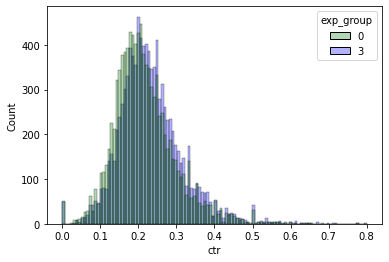

In [ ]:
# Смотрим распределение CTR в группах 0 и 3
sns.histplot(data=df_0_3, hue='exp_group', x='ctr', palette=['g', 'b'], kde=False, alpha=0.3 )

In [ ]:
# Посмотрим что датет проверка на нормальность теста Колмогорова-Смирнова для 0 и 3
# поскольку группы 1 и 2 уже проверены - распределения не нормальны - дисперсии не равны
stat0, p0 = stats.kstest(df_0_3[df_0_3.exp_group == 0].ctr,'norm')
stat3, p3 = stats.kstest(df_0_3[df_0_3.exp_group == 3].ctr,'norm')
print(f'Для группы 0: Statistic = {stat0:.2f}, Pvalue = {p0:.2f}\n'
      f'Для группы 3: Statistic = {stat3:.2f}, Pvalue = {p3:.2f}')

Для группы 0: Statistic = 0.51, Pvalue = 0.00
Для группы 3: Statistic = 0.52, Pvalue = 0.00


In [ ]:
Нулевую гипотезу о нормальности 0 и 3 групп отклоняеем

In [ ]:
# Применяем тест Левена для проверки равенства дисперсий 0 и 3 групп
stat, p_value = stats.levene(df_0_3[df_0_3.exp_group == 0].ctr, df_0_3[df_0_3.exp_group == 3].ctr)

print(f'Statistic levene = {stat:.2f} Pvalue = {p_value:.2f}')

Statistic levene = 5.03 Pvalue = 0.02


In [ ]:
Дисперсии групп 0 и 3 не равны

In [ ]:
# Т-тест на обычных параметрах
stat_t, p_t = stats.ttest_ind(df_0_3[df_0_3.exp_group == 0].ctr,
                df_0_3[df_0_3.exp_group == 3].ctr, equal_var=False)
print(f'T -test Statistic = {stat_t:.2f} Pvalue = {p_t}')

T -test Statistic = -13.94 Pvalue = 6.216047483062228e-44


In [ ]:
pvalue=6.216047483062228e-44 при данных условиях - значимые различия между группами

In [ ]:
# Делаем линеаризованые параметры для 0 и 3 групп
# Запрос в кликхаус который достает общегрупповой CTR  в контрольной 0 группе
# Затем для каждого пользователя like - ctr_control*view
q = """
SELECT exp_group, likes - views*ctr_control as linear_likes
FROM(SELECT
        exp_group,
        user_id,
        toInt64(sum(action = 'like')) as likes,
        toInt64(sum(action = 'view')) as views,
        (SELECT sum(action = 'like')/sum(action = 'view')
         FROM simulator_20250120.feed_actions
         WHERE  toDate(time) >= toDate('2025-01-03')
         and toDate(time) <= toDate('2025-01-09')
         and exp_group = 0) as ctr_control
     FROM
          simulator_20250120.feed_actions
     WHERE
         toDate(time) >= toDate('2025-01-03')
         and toDate(time) <= toDate('2025-01-09')
         and exp_group in (0, 3)
         GROUP BY exp_group, user_id) t1
"""
df_linear = ph.read_clickhouse(q, connection=connection)

<Axes: xlabel='linear_likes', ylabel='Count'>

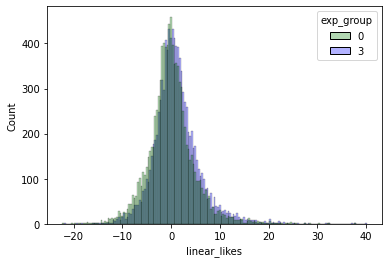

In [ ]:
# Посмотрим распределение линеаризованных лайков
sns.histplot(data=df_linear, x='linear_likes', hue='exp_group', palette=['g', 'b'], kde=False, alpha=0.3)

In [ ]:
Визуально распределения стали более симметричными и имеют меньше выбросов.
Линеаризация - т.е. приведение метрики отношения к линейной величине, делает оценку
более однозначной и не зависящей от просмотров. Мы смотрим на сколько каждый пользователь в тесте
и контроле отклоняется от некоторого базоваго уровня. Распределение ближе к нормальному, что важно для t-теста

In [ ]:
# Посмотрим на тест Колмогорова-Смирнова на линеаризованной метрике
stat_l_0, p_l_0 = stats.kstest(df_linear[df_linear.exp_group == 0].linear_likes, 'norm')
stat_l_3, p_l_3 = stats.kstest(df_linear[df_linear.exp_group == 3].linear_likes, 'norm')
print(f'Linear 0 Statistic = {stat_l_0}, Pvalue = {p_l_0}\n'
      f'Linear 3 Statistic = {stat_l_3}, Pvalue = {p_l_3}')
# Нулевую гипотезу о нормальности распределения отклоняеем для обеих выборок

Linear 0 Statistic = 0.2857947267766135, Pvalue = 0.0
Linear 3 Statistic = 0.34048818040552, Pvalue = 0.0



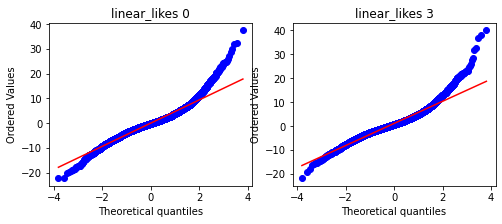

In [ ]:
#  Q-Q plot
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
stats.probplot(df_linear[df_linear.exp_group == 0].linear_likes, dist="norm", plot=plt)
plt.title('linear_likes 0')
plt.subplot(1, 2, 2)
stats.probplot(df_linear[df_linear.exp_group == 3].linear_likes, dist="norm", plot=plt)
plt.title('linear_likes 3')
plt.show()

In [ ]:
Всеже хвосты распределения сильно вытянуты что искажает нормальность распределения

In [ ]:
# Т-тест на линеаризованных параметрах 0 и 3
stat_tl, p_tl = stats.ttest_ind(df_linear[df_linear.exp_group == 0].linear_likes,
                df_linear[df_linear.exp_group == 3].linear_likes, equal_var=False)
print(f'T -test Statistic = {stat_tl:.2f} Pvalue = {p_tl}')

T -test Statistic = -16.19 Pvalue = 1.4918137745326139e-58


In [ ]:
Т-тест на линеаризованной метрике как и на обычной дает стат занчимые различия между группами
Но линеаризованное Pvalue в 41,6 миллионов раз меньше обычного - тест стал много точнее.

In [ ]:
# Запрос для групп 1 и 2 обычные параметры
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-09')
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""
df_1_2 = ph.read_clickhouse(q, connection=connection)

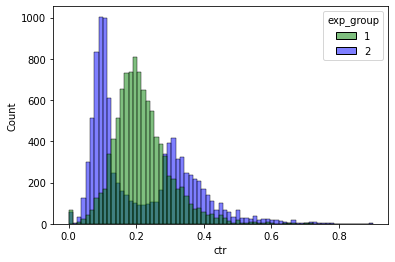

In [ ]:
# Смотрим распределение исходных групп 1 и 2
sns.histplot(data=df_1_2, hue='exp_group', x='ctr', palette=['g', 'b'], kde=False, alpha=0.5 )
plt.show()

In [ ]:
# Для данных групп известно что дисперсиине равны и распределения не нормальны
# Т-тест на обычных параметрах 1 и 2
stat_t12, p_t12 = stats.ttest_ind(df_1_2[df_1_2.exp_group == 1].ctr,
                df_1_2[df_1_2.exp_group == 2].ctr, equal_var=False)
print(f'T -test Statistic = {stat_t12:.2f} Pvalue = {p_t12}')

T -test Statistic = 0.41 Pvalue = 0.685373331140751


In [ ]:
pvalue=0.685373331140751 при данных условиях - значимых различий между группами нет

In [ ]:
# Делаем линеаризованые параметры для 1 и 2 групп
q = """
SELECT exp_group, likes - views*ctr_control as linear_likes
FROM(SELECT
          exp_group,
          user_id,
          toInt64(sum(action = 'like')) as likes,
          toInt64(sum(action = 'view')) as views,
          (SELECT sum(action = 'like')/sum(action = 'view')
           FROM simulator_20250120.feed_actions
           WHERE  toDate(time) >= toDate('2025-01-03')
             and toDate(time) <= toDate('2025-01-09')
             and exp_group = 1) as ctr_control
    FROM
      simulator_20250120.feed_actions
    WHERE
      toDate(time) >= toDate('2025-01-03')
      and toDate(time) <= toDate('2025-01-09')
      and exp_group in (1, 2)
    GROUP BY
      exp_group,
      user_id) t1
"""
df_linear = ph.read_clickhouse(q, connection=connection)

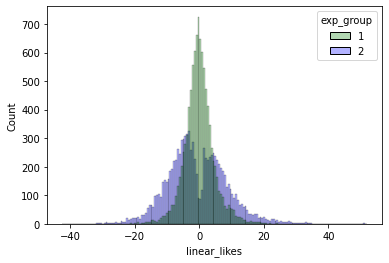

In [ ]:
# Посмотрим распределение линеаризованных лайков для 1 и 2 групп
sns.histplot(data=df_linear, x='linear_likes', hue='exp_group', palette=['g', 'b'], kde=False, alpha=0.3)
plt.show()

In [ ]:
Линеаризация стягивает распределение в сторону нормального, но два максимума также остаются

In [ ]:
# Т-тест на линеаризованных параметрах 1, 2 группы
stat_lin12, p_lin12 = stats.ttest_ind(df_linear[df_linear.exp_group == 1].linear_likes,
                df_linear[df_linear.exp_group == 2].linear_likes, equal_var=False)
print(f'T -test Statistic = {stat_lin12:.2f} Pvalue = {p_lin12}')

T -test Statistic = 5.94 Pvalue = 2.9805064038668388e-09


In [ ]:
Линеаризованное Pvalue для групп 1 и 2 почти в миллиард раз меньше чем для обычных данных (Pvalue = 0.69), при этом
на линеаризованной метрике есть стат значимые различия между группами. Линеаризация — это очень быстрый метод, повышает
чувствительность для всех рассмотренных случаев. Это достигается во многом тем, что полученная метрика является
сонаправленной с глобальным CTR — то есть если глобальный CTR растёт, то и эта метрика растёт, и наоборот.
Это делает метод гораздо более ресурсоэффективной заменой пуассоновскому бутстрапу.